In [1]:
import os
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import class_weight
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, Input, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.applications import ResNet50

Using TensorFlow backend.


In [2]:
drive_base_path = "../"
path_to_images = drive_base_path + "dataset/ISIC2018_Training_Input/"
path_to_balanced_images = drive_base_path + "dataset/ISIC2018_Balanced_Training_Input/"

In [3]:
def load_sample(path_to_images, number_of_images):
    list_of_images = os.listdir(path_to_images)
    x = []
    for i, filename in enumerate(list_of_images):
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x.append(image)
        
        if i >= number_of_images:
            break
    
    x = np.array(x)
    return x       

In [4]:
x = load_sample(path_to_images, 1000)
print(x.shape)

(1001, 450, 600, 3)


In [5]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    data_format="channels_last")

In [6]:
datagen.fit(x)

In [7]:
classes = ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']
train_generator = datagen.flow_from_directory(
                    directory=path_to_balanced_images,
                    target_size=(224, 224),
                    batch_size=32,
                    classes=classes,
                    shuffle=True)

Found 32404 images belonging to 7 classes.


In [8]:
samples = train_generator.samples

In [9]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

print(class_weights)

[1.0397895  0.69040162 1.28658779 1.08895386 1.05303523 1.0063354
 1.05159992]


# DEFINING THE MODEL

In [10]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(lr=1e-3), 
              metrics=["acc"])
print(model.summary())

/data/anaconda/envs/py36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [11]:
batch_size = 32
epochs = 3
history = model.fit_generator(train_generator, 
                              epochs=epochs,
#                               class_weight=class_weights,
                              steps_per_epoch=samples / batch_size,
                              verbose=1)

Epoch 1/3
1013/1012 [==============================] - 552s 545ms/step - loss: 0.8675 - acc: 0.6801
Epoch 2/3
1013/1012 [==============================] - 551s 544ms/step - loss: 0.6582 - acc: 0.7569
Epoch 3/3
1013/1012 [==============================] - 551s 544ms/step - loss: 0.5931 - acc: 0.7792


In [12]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

for layer in model.layers[:161]:
    layer.trainable = False
for layer in model.layers[161:]:
    layer.trainable = True

# for i, layer in enumerate(model.layers):
#     print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1 False
3 bn_conv1 False
4 activation_1 False
5 pool1_pad False
6 max_pooling2d_1 False
7 res2a_branch2a False
8 bn2a_branch2a False
9 activation_2 False
10 res2a_branch2b False
11 bn2a_branch2b False
12 activation_3 False
13 res2a_branch2c False
14 res2a_branch1 False
15 bn2a_branch2c False
16 bn2a_branch1 False
17 add_1 False
18 activation_4 False
19 res2b_branch2a False
20 bn2b_branch2a False
21 activation_5 False
22 res2b_branch2b False
23 bn2b_branch2b False
24 activation_6 False
25 res2b_branch2c False
26 bn2b_branch2c False
27 add_2 False
28 activation_7 False
29 res2c_branch2a False
30 bn2c_branch2a False
31 activation_8 False
32 res2c_branch2b False
33 bn2c_branch2b False
34 activation_9 False
35 res2c_branch2c False
36 bn2c_branch2c False
37 add_3 False
38 activation_10 False
39 res3a_branch2a False
40 bn3a_branch2a False
41 activation_11 False
42 res3a_branch2b False
43 bn3a_branch2b False
44 activation_12 False
45 res3a_branch2c False

In [13]:
model.compile(optimizer=SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=["acc"])
epochs = 15
batch_size = 32
history = model.fit_generator(train_generator, 
                              steps_per_epoch=samples / batch_size,
                              epochs=epochs,
#                               class_weight=class_weights,
                              verbose=1)
model.save_weights(drive_base_path + 'models/ResNet50_ISIC.h5')
# model.evaluate(X_test, y_test)

Epoch 1/15
1013/1012 [==============================] - 551s 544ms/step - loss: 0.5062 - acc: 0.8117
Epoch 2/15
1013/1012 [==============================] - 550s 543ms/step - loss: 0.4825 - acc: 0.8207
Epoch 3/15
1013/1012 [==============================] - 550s 543ms/step - loss: 0.4552 - acc: 0.8341
Epoch 4/15
1013/1012 [==============================] - 550s 543ms/step - loss: 0.4390 - acc: 0.8410
Epoch 5/15
 636/1012 [=================>............] - ETA: 3:24 - loss: 0.4237 - acc: 0.8434

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1013/1012 [==============================] - 549s 542ms/step - loss: 0.4052 - acc: 0.8521
Epoch 7/15
1013/1012 [==============================] - 550s 543ms/step - loss: 0.3885 - acc: 0.8587
Epoch 8/15
1013/1012 [==============================] - 549s 542ms/step - loss: 0.3785 - acc: 0.8654
Epoch 9/15
1013/1012 [==============================] - 550s 543ms/step - loss: 0.3623 - acc: 0.8702
Epoch 10/15
1013/1012 [==============================] - 549s 542ms/step - loss: 0.3527 - acc: 0.8727
Epoch 11/15
1013/1012 [==============================] - 549s 542ms/step - loss: 0.3432 - acc: 0.8767
Epoch 12/15
1013/1012 [==============================] - 549s 542ms/step - loss: 0.3367 - acc: 0.8802
Epoch 13/15
1013/1012 [==============================] - 549s 542ms/step - loss: 0.3253 - acc: 0.8838
Epoch 14/15
1013/1012 [==============================] - 549s 542ms/step - loss: 0.3117 - acc: 0.8894
Epoch 15/15
1013/1012 [==============================] - 549s 542ms/step - loss: 0.3083 - acc: 0.

# ACCURACY AND LOSS PLOTS

dict_keys(['loss', 'acc'])


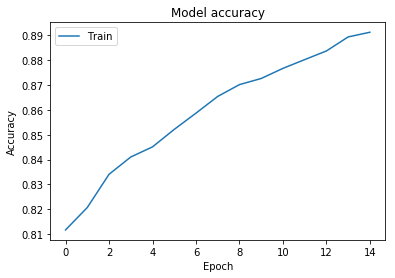

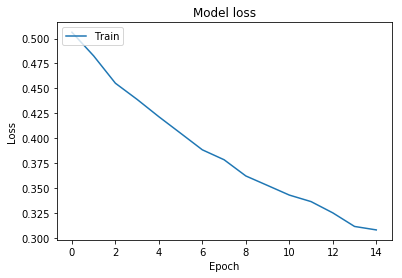

In [14]:
# Plot Training and Validation Accuracy
print(history.history.keys())
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# ISIC LIVE IMAGE TEST/VALIDATION DATA

In [15]:
# TESTTING ON ISIC LIVE IMAGE DATA
path_to_images = drive_base_path + "dataset/ISIC2018_Task3_Test_Input/"

In [16]:
def preprocess_images(path_to_images):
    images_list = []
    filename_list = []
    
    path_to_images = path_to_images + 'test/'
    
    input_size = 224
    list_of_images = os.listdir(path_to_images)
    number = len(list_of_images)
    
    for filename in tqdm(list_of_images, total=number):
        filename_list.append(filename[:-4])
        
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (input_size, input_size))

        arr = np.array(image)
        images_list.append(image)
        
    images_list = np.array(images_list)
    filename_list = np.array(filename_list)
    filename_list = filename_list[:, None]
    return (images_list, filename_list)

In [17]:
x_test, names = preprocess_images(path_to_images)

In [18]:
print(x_test.shape)
print(names.shape)

(1512, 224, 224, 3)
(1512, 1)


In [19]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [20]:
datagen.fit(x_test)

In [21]:
test_generator = datagen.flow(
                    x_test,
                    batch_size=1,
                    shuffle=False)

In [ ]:
model.load_weights(drive_base_path + 'models/ResNet50_ISIC.h5')

In [22]:
predictions = model.predict_generator(test_generator, steps=len(x_test))
# classes = (predictions > 0.5).astype(np.float)
# print(classes.shape)

In [23]:
print(predictions.shape)

(1512, 7)


In [24]:
final_output = np.concatenate((names, predictions), axis=1)
final_output.shape

(1512, 8)

In [25]:
import csv

with open(drive_base_path + "output.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["image", "MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"])
    writer.writerows(final_output)